In [1]:
# IMPORT THE MODULES NEEDED
import os
import glob
import math
import random
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tensorflow.python.keras.utils import losses_utils
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import normalize
from classification_models.tfkeras import Classifiers

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

# Use only one GPU, comment this out for using all GPUs
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [2]:
## Define the parameters of the network and the save/log/data directories
# Change parameters here...
sizex = 128                 # 128 x
sizey = 128                 # 128 pixels
sizez = 3                   # 3 color channels: RGB
rand_seed = 666             # Seed for random processes
batch_size = 32 * 2         # Size of batches passed to the GPU(s)
nb_epochs = 100             # Number of epochs for training
validation_ratio = 0.2      #Ratio of dataset used as validation
use_dust = False            # Parameter to also use images with dust rendered
log_dir = "../logs/"        # Where log files will be saved
data_dir = '../data/'       # Where data is stored
resnet_select = 'resnet18'  # Define the desired resnet model

# Ensure log file directory
os.makedirs(log_dir, exist_ok=True)

# Propare output filenames
model_name = resnet_select + '_bs' + str(batch_size)
if use_dust: model_name += '_dust'
snapshot_weights = 'models/best_'+model_name+'.hdf5'
last_snapshot_weights = 'models/last_'+model_name+'.hdf5'
json_name = 'models/json_'+model_name+'.json'
trained_model = 'models/trained_'+model_name+'.h5'

In [3]:
# Loss function: Use negative log likelihood for a PDF output
negloglik = lambda y, p_y: -p_y.log_prob(y)

In [4]:
# Define the strategy and check GPUs available
strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Defining the model in all the devices (GPU's) available
# import the prefdefined model
ResNet, preprocess_input = Classifiers.get(resnet_select)

# Build the model
with strategy.scope():
    # Image classification network
    model = ResNet(input_shape=(sizex, sizey, sizez), include_top=False)

    # Resizing (Pooling) and bottle neck
    globavg = tf.keras.layers.GlobalAveragePooling2D()(model.layers[-1].output)
    dense1 = tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu)(globavg)
    drop1 =  tf.keras.layers.Dropout(rate = 0.2)(dense1)
    dense2 = tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu)(drop1)
    drop2 =  tf.keras.layers.Dropout(rate = 0.2)(dense2)
    dense3 = tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(drop2)
    drop3 =  tf.keras.layers.Dropout(rate = 0.2)(dense3)
    dense4 = tf.keras.layers.Dense(2)(drop3)
    
    # Change the output to a normal PDF. Remember to set a layer with 
    # 2 neurons (mean and std) before it
    output = tfpl.IndependentNormal(event_shape=1)(dense4)
 
    model = tf.keras.models.Model(inputs=model.inputs, outputs=output)
    
    # Compile the model specifying the optimazer (sgd) and the loss function and other metrics
    model.compile(optimizer= tf.keras.optimizers.SGD(),
                  loss= negloglik, metrics=[
                                                       tf.keras.metrics.mean_absolute_error,])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Num GPUs Available:  4
Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [5]:
# See a sumary of the model with all the layers and parameters
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 500, 500, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 506, 506, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 250, 250, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [6]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'datasetpickle*')

# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets:
    with np.load(dataset) as data:
        if 'y' in data_dict.keys():
            #data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
            data_dict['mass']      = np.append( data_dict['mass'], data['mass'],axis=0)
            data_dict['star_mass']      = np.append( data_dict['star_mass'], data['star_mass'],axis=0)
        else:
            #data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']
            data_dict['mass']      = data['mass']
            data_dict['star_mass']      = data['star_mass']
            
data_dict['ids'] = np.array(data_dict['ids'], dtype = str)

In [8]:
# Filter the galaxies that have less than 1e10 solar masses or completely
# black images
a = np.amax(data_dict['x_nodust'], axis = (1,2,3))
bad_ids = [[galaxy_id,i] for galaxy_id,i in zip(data_dict['ids'],range(len(data_dict['ids']))) if 'e09' in galaxy_id or a[i]<0.5]
bad_ids = np.array(bad_ids)
remove_galaxies = np.array(bad_ids[:,1],dtype=int)

print('there are ', len(bad_ids), ' galaxies to remove')

for key in data_dict.keys():
    data_dict[key] = np.delete(data_dict[key],remove_galaxies, axis=0)
    
print('Still have ', len(data_dict['ids']), ' galaxies left')

# Define dataset size and buffer size to use the whole dataset
ds_size = len(data_dict['ids'])
buf_size = 2*ds_size

train_size = int(np.floor((1-validation_ratio)*ds_size))
val_size = int(np.ceil(validation_ratio*ds_size))

# Obtain names of unique galaxies in the dataset
ALLuniqueids = data_dict['ids'].copy()
for ii in range(np.size(data_dict['ids'])):
    ALLuniqueids[ii] = data_dict['ids'][ii][:data_dict['ids'][ii].index('e')+3]
uniqueids = np.unique(ALLuniqueids)

train_uniqueids_num = int(np.floor((1-validation_ratio)*np.size(uniqueids)))
val_uniqueids_num = int(np.ceil(validation_ratio*np.size(uniqueids)))

# Generate random indexes to chose train and validation galaxies
random.seed(rand_seed)
randindexes = random.sample(range(np.size(uniqueids)), np.size(uniqueids))

# Get masks to select training and validation samples
train_mask = np.isin(ALLuniqueids, uniqueids[randindexes[:train_uniqueids_num]])
val_mask = np.isin(ALLuniqueids, uniqueids[randindexes[train_uniqueids_num:]])

there are  490  galaxies to remove
Still have  405  galaxies left
['g4.90e11_x134_y286_z196' 'g4.90e11_x26_y285_z64'
 'g4.90e11_x239_y101_z98' 'g4.90e11_x170_y94_z15'
 'g4.90e11_x147_y176_z286']
shape of image's array (405, 500, 500, 3)
shape of the label's array (405, 3)


In [9]:
# computing the normaliced vectors in 3D
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)

In [10]:
# Functions to do the augmentation

# 50% Chance to flip an image left to right. If it does,
# change the x component of angular momentum accordingly
def random_flip_lr(image, label, seed=None):
    img = tf.image.random_flip_left_right(image, seed=seed)
    if tf.reduce_all(tf.equal(img,image)):
        label_f = label
    else:
        label_f = tf.convert_to_tensor([-label[0],label[1]])
    return (img, label_f)

# 50% Chance to flip an image up to down. If it does,
# change the y component of angular momentum accordingly
def random_flip_ud(image, label, seed=None):
    img = tf.image.random_flip_up_down(image, seed=seed)
    if tf.reduce_all(tf.equal(img,image)):
        label_f = label
    else:
        label_f = tf.convert_to_tensor([label[0],-label[1]])
    return (img,label_f)

# Rotate the image randomly, return the angle with respect to
# x-axis as new label.
def random_rot(image, label, seed=None):
    
    # Define the number of radians to rotate. 24 possible rotations
    number_of_intervalls = 24
    rad = tf.random.uniform(shape=[1], minval=0, maxval=2*math.pi, dtype=tf.float32)
    rad = rad//(2*math.pi/number_of_intervalls) * (2*math.pi/number_of_intervalls)
    
    # Transform images
    img = tfa.image.rotate(image, rad, interpolation = 'BILINEAR')
    
    # Transform J components
    x = tf.math.multiply(tf.math.cos(-rad), label[0]) - tf.math.multiply(tf.math.sin(-rad), label[1])
    y = tf.math.multiply(tf.math.sin(-rad), label[0]) + tf.math.multiply(tf.math.cos(-rad), label[1])
    
    # Obtain angle and restrict to quadrants 1 and 4
    label_f = tf.math.atan2(y,x)*180/np.pi
    if label_f > 90:
        label_f-=180
    if label_f <= -90:
        label_f += 180
        
    # Renormalize: from -1 to 1
    label_f = label_f / 90
    
    return (img,label_f)

# Perform the three previous steps of augmentation
def augment(img, label):
    img_f,label_f = random_flip_lr(img,label)
    img_f,label_f = random_flip_ud(img_f,label_f)
    img_f,label_f = random_rot(img_f,label_f)
    return (img_f, label_f)

In [11]:
# MAKE DATASETS IN THE USUAL WAY

# Import the autotune option from TF
AUTO = tf.data.experimental.AUTOTUNE

# Defining the train and validation dataset from the existing dictionary, shufling and batching
input_ds_nodust = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32),
                                        data_dict['y_norm'][:,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))

# Compute the val_size dataset in terms of the ds_size and the validation_ratio that we have
val_size = math.floor(ds_size * validation_ratio)

# Cache and augment the dataset (THE ORDER IS IMPORTANT!!)
validation_ds_nodust_aug =  (input_ds_nodust.take(val_size).cache()
                            .map(augment, num_parallel_calls=AUTO))
train_ds_nodust_aug      =  (input_ds_nodust.skip(val_size).cache()
                            .map(augment, num_parallel_calls=AUTO))

# If dust is activated compute the dust datasets
if use_dust:
    input_ds_dust = (
        tf.data.Dataset.from_tensor_slices((data_dict['x_dust'].astype(np.float32),
                                            data_dict['y_norm'][:,:2].astype(np.float32)))
                       .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))
    
    input_ds_dust = input_ds_dust.take(ds_size)
    validation_ds_dust_aug = (input_ds_dust.take(val_size).cache()
                              .map(augment, num_parallel_calls=AUTO))
    train_ds_dust_aug =  (input_ds_dust.skip(val_size).cache()
                          .map(augment, num_parallel_calls=AUTO))
    
    # concatenate both datasets (dust and no dust) and repeat the data and batch it
    train_ds = (train_ds_dust_aug.concatenate(train_ds_nodust_aug)
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .repeat(48).batch(batch_size).prefetch(AUTO))
    validation_ds = (validation_ds_dust_aug.concatenate(validation_ds_nodust_aug)
                    .repeat(48).batch(batch_size).prefetch(AUTO))

else:
    # If dust is not activated compute the dataset from the nodust dataset and reapeat the data and batch it
    train_ds = (train_ds_nodust_aug
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .repeat(batch_size).batch(batch_size).prefetch(AUTO))
    validation_ds = (validation_ds_nodust_aug
                    .repeat(batch_size).batch(batch_size).prefetch(AUTO))

# Check all the datasets to see if they are correct
print("Validation set:")
print(validation_ds)
print("Size = " + str(tf.data.experimental.cardinality(validation_ds).numpy()))
print("Training set:")
print(train_ds)
print("Size = " + str(tf.data.experimental.cardinality(train_ds).numpy()))

<ParallelMapDataset shapes: ((500, 500, 3), (2,)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((500, 500, 3), (2,)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [ ]:
# MAKE DATASETS WITHOUT REPEATING GALAXIES

# Import the autotune option from TF
AUTO = tf.data.experimental.AUTOTUNE

# Defining the train and validation dataset from the existing dictionary, shufling and batching
input_train_nodust = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'][train_mask].astype(np.float32),
                                        data_dict['y_norm'][train_mask,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))
input_val_nodust = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'][val_mask].astype(np.float32),
                                        data_dict['y_norm'][val_mask,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))


# Cache and augment the dataset (THE ORDER IS IMPORTANT!!)
validation_ds_nodust_aug =  (input_val_nodust.take(val_size).cache()
                            .map(augment, num_parallel_calls=AUTO))
train_ds_nodust_aug      =  (input_train_nodust.take(train_size).cache()
                            .map(augment, num_parallel_calls=AUTO))

# If dust is activated compute the dust datasets
if use_dust:
    input_ds_dust = (
        tf.data.Dataset.from_tensor_slices((data_dict['x_dust'].astype(np.float32),
                                            data_dict['y_norm'][:,:2].astype(np.float32)))
                       .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))
    
    input_ds_dust = input_ds_dust.take(ds_size)
    validation_ds_dust_aug = (input_ds_dust.take(val_size).cache()
                              .map(augment, num_parallel_calls=AUTO))
    train_ds_dust_aug =  (input_ds_dust.skip(val_size).cache()
                          .map(augment, num_parallel_calls=AUTO))
    
    # concatenate both datasets (dust and no dust) and repeat the data and batch it
    train_ds = (train_ds_dust_aug.concatenate(train_ds_nodust_aug)
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .repeat(48).batch(batch_size).prefetch(AUTO))
    validation_ds = (validation_ds_dust_aug.concatenate(validation_ds_nodust_aug)
                    .repeat(48).batch(batch_size).prefetch(AUTO))

else:
    # If dust is not activated compute the dataset from the nodust dataset and reapeat the data and batch it
    train_ds = (train_ds_nodust_aug
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .repeat(batch_size).batch(batch_size).prefetch(AUTO))
    validation_ds = (validation_ds_nodust_aug
                    .repeat(batch_size).batch(batch_size).prefetch(AUTO))

# Check all the datasets to see if they are correct
print("Validation set:")
print(validation_ds)
print("Size = " + str(tf.data.experimental.cardinality(validation_ds).numpy()))
print("Training set:")
print(train_ds)
print("Size = " + str(tf.data.experimental.cardinality(train_ds).numpy()))

#### **cartesian label:** [-0.01522928 -0.74055016]

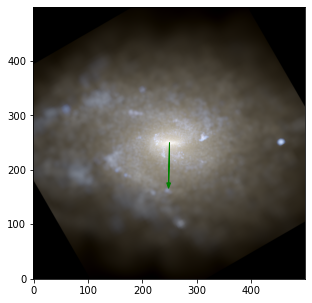

#### **cartesian label:** [0.2916508 0.8622017]

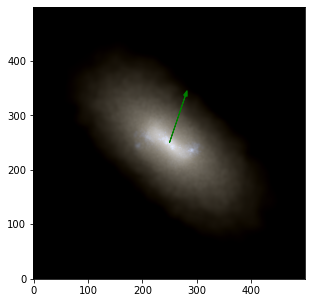

#### **cartesian label:** [ 0.11339864 -0.1840497 ]

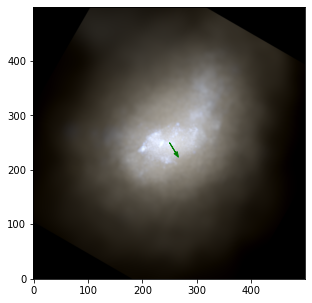

#### **cartesian label:** [-0.20544152  0.46177304]

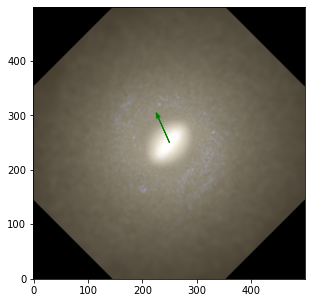

#### **cartesian label:** [-0.861621  -0.3787465]

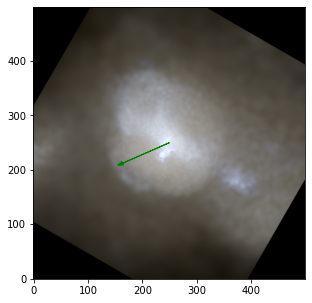

#### **cartesian label:** [ 0.43968436 -0.8790451 ]

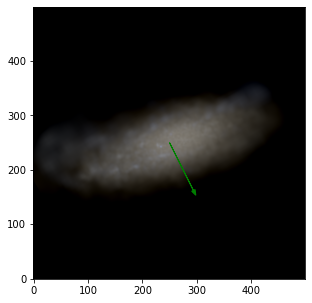

#### **cartesian label:** [-0.99708366  0.07580579]

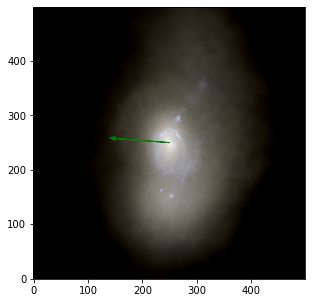

#### **cartesian label:** [-0.10584861  0.6768876 ]

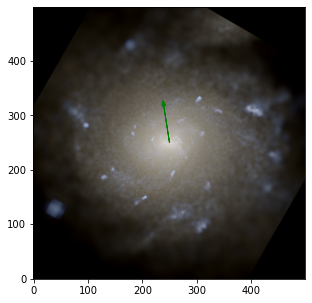

#### **cartesian label:** [-0.03517763  0.03252629]

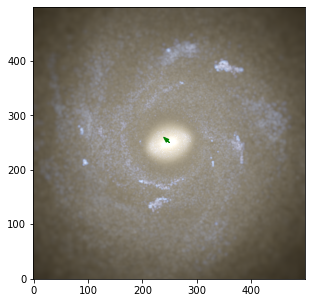

#### **cartesian label:** [0.81048733 0.4450612 ]

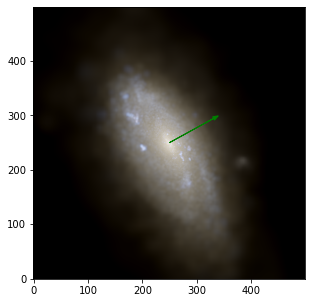

In [12]:
# function to visualice the data 
def viz(img, angle, idx, id=None):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(8,4))
    pdf = model(tf.expand_dims(img,[0]))
    predangle = float(pdf.mean())
    angle = angle*90
    predangle = predangle*90
    im = ax[0].imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    length = 5
    ax[0].arrow(64,64,1.5*length * math.cos(math.radians(angle)),1.5*length * math.sin(math.radians(angle)), head_width=7, head_length=10, fc='r', ec='r')
    ax[0].arrow(64,64,length * math.cos(math.radians(predangle)),length * math.sin(math.radians(predangle)), head_width=7, head_length=10, fc='g', ec='g')
    
    x = np.linspace(-1,1,1000)
    prob = []
    for jj in range(1000):
        prob.append(10**pdf.log_prob(x[jj]))
    ax[1].plot(x*90, prob, 'r', label = 'Predicted')
    ax[1].axvline(angle, color = 'g', label = 'Label')
    ax[1].set_xticks([-90,-60,-30,0,30,60,90])
    ax[1].legend()
    ax[1].set_label('Conter-Clockwise angle from E-W (º)')

    plt.savefig('ValidationFig-NoMix-'+str(idx)+'.png')
    print('Saved '+ 'ValidationFig-NoMix-'+str(idx)+'.png')
    plt.close()

for idx in range(1,64):
    elements = validation_ds.take(1)
    for elem in elements:
        viz(elem[0][idx], elem[1][idx], idx)#, elem['y_revs'][idx], id=elem['ids'][idx])
    
    

# function to visualice the data 
def viz(img, label, index, id=None):
    x = np.linspace(-1,1,1000)
    pdf = model(tf.expand_dims(img,[0]))
    prob = []
    for jj in range(1000):
        prob.append(10**pdf.log_prob(x[jj]))
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(x, prob)
    plt.axvline(label)
    fig.savefig('Trainfig-'+str(index)+'.png')
    plt.close()
    
    

# visualice the data
for idx in range(1,10):
    elements = train_ds.take(idx)
    for elem in elements:
        viz(elem[0][idx], elem[1][idx], idx)#, elem['y_revs'][idx], id=elem['ids'][idx])

In [ ]:
# For tensorboard to save the models
log_dir_s = log_dir + model_name
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

#Sefine the learning rate scheduler
def scheduler(epoch, lr):
    if epoch!=0 and epoch%20==0:
        print('Updated learning rate to '+str(lr/1.5))
        return lr/1.5
    else:
        return lr


# Checkpointing
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)
checkpointer_2 = tf.keras.callbacks.ModelCheckpoint(filepath=last_snapshot_weights,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=False)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [
    tensorboard_callback,
    checkpointer_1,
    checkpointer_2,
    LearningRateScheduler,
]

# Fit the model with the training and validation data, number of epochs and callbacks
history = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1


In [ ]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('errMSE-NEW-NoMix.png')
plt.close()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('lossMSE-NEW-NoMix.png')
plt.show()

In [ ]:
#save the last weights of the model
model.save(trained_model)


JORGE MANUEL SARRATO ALOS



In [ ]:
# taking samples from the validation dataset and evaluating the model
model.load_weights(snapshot_weights)
val_ex, = validation_ds.take(1)
train_ex, = train_ds.take(1)

images_v, labels_v = val_ex[0], val_ex[1]
images_t, labels_t = train_ex[0], train_ex[1]

#making the predictions for the taken images
outputs_v = model.predict(images_v)
outputs_t = model.predict(images_t)

In [ ]:
# visualicing the results
for img,label,pred,i in zip(images_t, labels_t, outputs_t,range(5)):
    viz(img, label, pred)

In [ ]:
for img,label,pred,i in zip(images_v, labels_v, outputs_v,range(5)):
    viz(img, label, pred)